# **Optimización de Modelos para la Predicción de Enfermedades Crónicas**

En la intersección de la inteligencia artificial y la salud pública, la capacidad para realizar diagnósticos tempranos y precisos de enfermedades crónicas representa un avance fundamental. La identificación proactiva de factores de riesgo no solo mejora los resultados clínicos para los pacientes, sino que también optimiza la asignación de recursos en los sistemas de salud.

Este notebook aborda dicho desafío mediante el desarrollo de un **modelo de aprendizaje automático de extremo a extremo**. Utilizando el conjunto de datos "Disease Prediction Using Machine Learning" de Kaggle, que comprende 132 variables sintomáticas para la predicción de 42 patologías distintas, se implementará una solución robusta y escalable.

El enfoque central de este proyecto no es solo construir un modelo predictivo, sino refinarlo hasta su máximo potencial a través de **técnicas avanzadas de ajuste de hiperparámetros**. Para ello, se explorarán y compararán dos de los frameworks de optimización más potentes en la industria:

1.  **Optuna:** Reconocido por su eficiencia y sus sofisticados algoritmos de muestreo que guían la búsqueda hacia las soluciones más prometedoras.
2.  **Ray Tune:** Una potente librería para la experimentación distribuida que permite paralelizar y escalar el proceso de optimización de manera masiva.

A lo largo de este análisis, se seguirá un riguroso pipeline que abarca desde el preprocesamiento y análisis exploratorio de los datos hasta la construcción de un modelo base, la optimización con ambas herramientas y, finalmente, una evaluación comparativa exhaustiva. El objetivo es obtener un modelo final de alta precisión, analizar su interpretabilidad para extraer conocimiento clínico valioso y ofrecer una perspectiva crítica sobre la eficiencia y aplicabilidad de cada técnica de optimización en un contexto real de salud pública.


### **Paso 0: Instalación y Configuración de Librerías**

Primero, nos aseguramos de tener todas las librerías necesarias.

### **1. Instalación de Librerías Especializadas**

```python
!pip install -q optuna "ray[tune]"
```

  * **Propósito General:** Esta línea instala dos librerías avanzadas para la optimización de hiperparámetros, que son críticas para el objetivo del proyecto.
  * **`!pip install`**: El signo de exclamación (`!`) indica al entorno (como Jupyter Notebook o Google Colab) que ejecute el comando siguiente en la terminal del sistema, no como código Python. `pip` es el gestor de paquetes de Python, y `install` es el comando para añadir nuevas librerías.
  * **`-q`**: Es la abreviatura de `--quiet` (silencioso). Suprime la mayor parte del texto informativo que se genera durante la instalación, mostrando únicamente errores. Esto mantiene la salida de la celda limpia y concisa.
  * **`optuna`**: Es el nombre de la primera librería. **Optuna** es un framework de optimización de hiperparámetros de última generación. Su función es automatizar el proceso de encontrar la mejor combinación de configuraciones para un modelo de machine learning (por ejemplo, el número de árboles en un Random Forest o la tasa de aprendizaje en una red neuronal), utilizando para ello algoritmos de búsqueda inteligentes.
  * **`"ray[tune]"`**: Es la segunda librería. **Ray** es un framework para la computación distribuida que facilita la paralelización de código Python para que se ejecute más rápido en múltiples núcleos de CPU o incluso en un clúster de máquinas. La parte `[tune]` especifica que se debe instalar el módulo **Ray Tune**, que es su componente especializado para la optimización de hiperparámetros a gran escala, permitiendo ejecutar cientos de pruebas de forma simultánea.

-----

### **2. Importación de Librerías Fundamentales y de Machine Learning**

Aquí se importan todas las dependencias que se utilizarán a lo largo del proyecto, asignándoles alias comunes para facilitar su uso.

  * **`import pandas as pd`**: Importa la librería **Pandas**, la herramienta estándar en Python para la manipulación y análisis de datos. Proporciona la estructura de datos `DataFrame`, que es una tabla bidimensional (similar a una hoja de cálculo) sobre la cual se pueden realizar operaciones de limpieza, filtrado, agrupación y transformación de datos de manera eficiente.
  * **`import numpy as np`**: Importa **NumPy** (Numerical Python), la librería fundamental para la computación científica. Su principal objeto es el array multidimensional, que permite realizar operaciones matemáticas y lógicas complejas sobre grandes volúmenes de datos numéricos de forma muy rápida. Es la base sobre la que se construyen Pandas y Scikit-learn.
  * **`import matplotlib.pyplot as plt`** y **`import seaborn as sns`**: Estas son las librerías de visualización de datos. **Matplotlib** es la base para crear todo tipo de gráficos estáticos, mientras que **Seaborn** está construida sobre Matplotlib y proporciona una interfaz de más alto nivel para crear gráficos estadísticos más atractivos y complejos con menos código.
  * **`from sklearn.preprocessing import LabelEncoder`**: De la librería **Scikit-learn** (`sklearn`), importa la clase `LabelEncoder`. Su función es convertir etiquetas categóricas (texto, como "Cáncer", "Gripe") en valores numéricos (0, 1, 2...), ya que los algoritmos de machine learning solo pueden procesar números.
  * **`from sklearn.model_selection import train_test_split`**: Importa la función `train_test_split`, una utilidad crucial para dividir el conjunto de datos en dos subconjuntos: uno para **entrenar** el modelo (`training set`) y otro para **evaluar** su rendimiento en datos que nunca ha visto (`testing set`). Esta práctica es fundamental para verificar si el modelo puede generalizar correctamente.
  * **`from sklearn.ensemble import RandomForestClassifier`**: Importa el `RandomForestClassifier`, que es el algoritmo de machine learning que se utilizará. Es un clasificador de "ensamble" que construye múltiples árboles de decisión y combina sus predicciones para obtener un resultado más preciso y robusto, reduciendo el riesgo de sobreajuste.
  * **`from sklearn.metrics import ...`**: Importa un conjunto de funciones para **evaluar el rendimiento del modelo**. Cada métrica ofrece una perspectiva diferente sobre la calidad de las predicciones:
      * `accuracy_score`: Porcentaje total de predicciones correctas.
      * `precision_score`: De todas las predicciones positivas, cuántas fueron realmente correctas. Es importante cuando el coste de un falso positivo es alto.
      * `recall_score`: De todos los casos positivos reales, cuántos fueron identificados correctamente. Es clave cuando el coste de un falso negativo es alto (p. ej., no detectar una enfermedad).
      * `f1_score`: La media armónica de precisión y recall, útil para tener una única métrica que equilibre ambas.
      * `roc_auc_score`: Mide la capacidad del modelo para distinguir entre clases. Un valor de 1.0 es perfecto, mientras que 0.5 es aleatorio.
      * `classification_report` y `confusion_matrix`: Herramientas para obtener un resumen detallado del rendimiento por cada clase y visualizar los aciertos y errores del modelo.

-----

### **3. Configuración del Entorno de Ejecución**

Estas líneas ajustan el comportamiento del entorno para mejorar la legibilidad y la estética de los resultados.

  * **`warnings.filterwarnings('ignore')`**: Instruye a Python para que ignore y no muestre mensajes de advertencia (`warnings`). Esto se hace a menudo en informes finales para que la salida sea más limpia, aunque durante el desarrollo es recomendable prestar atención a estas advertencias.
  * **`plt.style.use('seaborn-v0_8')`**: Establece el estilo visual por defecto para todos los gráficos generados con Matplotlib, utilizando una plantilla que imita la estética de la librería Seaborn, generalmente considerada más moderna y legible.
  * **`sns.set_palette("husl")`**: Define la paleta de colores por defecto que usará Seaborn en sus gráficos. La paleta "husl" (Hue, Saturation, Lightness) está diseñada para ofrecer colores que son fáciles de distinguir, incluso para personas con daltonismo.

-----

### **4. Mensaje de Confirmación**

  * **`print("✅ Librerías importadas y configuración inicial completada.")`**: Finalmente, esta línea imprime un mensaje en la consola para confirmar al usuario que todas las celdas de configuración se han ejecutado correctamente y el entorno está listo para comenzar el análisis. El emoji `✅` sirve como un indicador visual claro de éxito.

In [18]:
!pip install -q optuna "ray[tune]"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)

# Configuraciones de visualización y advertencias
# warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Librerías importadas y configuración inicial completada.")

✅ Librerías importadas y configuración inicial completada.


### **Paso 1: Selección y Comprensión del Conjunto de Datos**

En esta sección, cargaremos los datos de entrenamiento y prueba. Realizaremos un análisis exploratorio para entender su estructura, distribución y características principales.

Por supuesto, aquí tienes la misma explicación profesional y detallada, pero redactada enteramente en texto, sin incluir las líneas de código.

---

### **Análisis del Script de Montaje y Descompresión en Google Colab**

Este script está diseñado para ser ejecutado en un entorno de Google Colaboratory, y su objetivo es automatizar la preparación de datos para un análisis. Concretamente, establece una conexión con el Google Drive del usuario para acceder a un archivo comprimido y luego extrae su contenido en el entorno de trabajo temporal de Colab.

**1. Conexión y Montaje de Google Drive**

Inicialmente, el script importa un módulo exclusivo del ecosistema de Google Colab, diseñado para interactuar con Google Drive. Inmediatamente después, ejecuta la función de "montaje".

Esta operación es fundamental, ya que los entornos de Colab son temporales y se borran al cerrar la sesión. El montaje crea un puente entre el sistema de archivos de esta máquina virtual efímera y el almacenamiento persistente de Google Drive. En la práctica, hace que todo el contenido de tu Drive aparezca como una carpeta local dentro de Colab, accesible a través de una ruta predeterminada. La primera vez que se realiza esta acción, el sistema solicita al usuario que se autentique y conceda los permisos necesarios para que Colab pueda leer sus archivos.

**2. Preparación para la Descompresión**

A continuación, el script importa la librería estándar de Python para manejar archivos comprimidos en formato ZIP.

Luego, define dos variables de texto para organizar el proceso. La primera variable almacena la ruta completa y exacta donde se encuentra el archivo ZIP dentro de Google Drive. Esta ruta parte desde la raíz del sistema de Colab, navega hasta el punto de montaje de Drive y finalmente apunta al archivo específico en la "Mi unidad" del usuario. La segunda variable simplemente define el nombre de la carpeta que se creará en el entorno de Colab para alojar los archivos descomprimidos. El uso de variables para estas rutas es una buena práctica que hace el código más legible y fácil de mantener.

**3. Proceso de Extracción del Archivo**

El núcleo de la operación se realiza utilizando un "gestor de contexto", una construcción de Python que garantiza un manejo seguro de los archivos. Este gestor abre el archivo ZIP especificado en modo de solo lectura y lo asigna a una referencia temporal.

La principal ventaja de este método es la seguridad: asegura que el archivo se cierre correctamente de forma automática una vez que la operación termina, incluso si se produce un error inesperado, previniendo así la corrupción de datos o el consumo innecesario de recursos.

Dentro de este bloque seguro, se invoca un método que lee todo el contenido del archivo comprimido y lo extrae en la carpeta de destino. Si esta carpeta de destino aún no existe en el entorno de Colab, es creada automáticamente por esta función.

**4. Notificación al Usuario**

Finalmente, como una buena práctica de experiencia de usuario, el script concluye imprimiendo un mensaje de confirmación en la pantalla. Este texto informa al usuario que el proceso de extracción ha concluido con éxito y le recuerda el nombre de la carpeta donde puede encontrar los datos ya listos para ser utilizados.

In [19]:
# Importa la librería de Google Drive para montar el sistema de archivos.
from google.colab import drive
# Monta Google Drive en el directorio '/content/drive' para acceder a los archivos.
drive.mount('/content/drive')

# Importa la librería zipfile para manejar archivos comprimidos.
import zipfile

# Define la ruta del archivo ZIP que se encuentra en tu Google Drive.
ruta_zip = "/content/drive/MyDrive/archive.zip"
# Define el nombre del directorio donde se extraerán los archivos.
directorio_destino = "dataset_final"

# Abre el archivo ZIP en modo lectura ('r').
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    # Extrae todo el contenido del archivo ZIP en el directorio de destino.
    zip_ref.extractall(directorio_destino)

# Imprime un mensaje de confirmación para el usuario.
print(f"Archivos extraídos en la carpeta '{directorio_destino}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivos extraídos en la carpeta 'dataset_final'


### **Análisis del Script de Carga y Exploración de Datos**

Este script de Python representa la fase inicial y fundamental de un proyecto de aprendizaje automático, conocida como **Análisis Exploratorio de Datos (EDA)**. Su objetivo es cargar los conjuntos de datos de entrenamiento y prueba, realizar una limpieza básica y luego analizar la estructura y distribución de los datos para obtener una comprensión profunda del problema antes de construir un modelo.

---

### **1. Carga y Preparación de los Datos**

El proceso comienza con una función dedicada a cargar los datos. Esta función intenta leer dos archivos en formato CSV, uno para entrenamiento y otro para pruebas, desde un subdirectorio específico. Si la operación es exitosa, imprime en pantalla una confirmación junto con las dimensiones de cada conjunto de datos (número de filas y columnas), lo cual es un primer paso esencial para verificar que los datos se han cargado correctamente.

A continuación, realiza una operación de limpieza muy específica: busca y elimina una columna anómala que a veces se genera al guardar archivos CSV, comúnmente llamada 'Unnamed: 133'. Este paso demuestra una atención al detalle y un conocimiento práctico de los problemas comunes en la manipulación de datos.

La función está encapsulada en un bloque de manejo de errores. Esto significa que si los archivos CSV no se encuentran en la ruta especificada, el programa no se detendrá con un error. En su lugar, mostrará un mensaje claro y amigable al usuario, indicando el problema y cómo solucionarlo, lo cual es una práctica de programación robusta y profesional.

---

### **2. Análisis Exploratorio del Conjunto de Datos**

Una vez que los datos de entrenamiento se han cargado exitosamente, una segunda función se encarga de realizar el análisis exploratorio.

Primero, extrae y presenta **metadatos clave** del conjunto de datos: el número total de características (que en este contexto son los síntomas) y el número total de clases únicas (las diferentes enfermedades a predecir). Esta información es crucial para entender la escala y complejidad del problema de clasificación.

Luego, el script se enfoca en la **variable objetivo**, es decir, la columna que contiene los nombres de las enfermedades. Calcula la frecuencia de cada enfermedad para entender su distribución. A partir de esto, determina si el conjunto de datos está **balanceado**, es decir, si hay un número similar de ejemplos para cada enfermedad. Esta verificación es de vital importancia, ya que un desequilibrio severo en las clases puede sesgar el modelo de aprendizaje y requeriría técnicas especiales de mitigación.

Finalmente, para complementar el análisis numérico, el script genera una **visualización**. Crea un gráfico de barras horizontal que muestra el número de casos para cada enfermedad. Este gráfico permite una interpretación visual e intuitiva de la distribución de las clases, facilitando la identificación de las enfermedades más y menos frecuentes en el conjunto de datos de un solo vistazo. El gráfico está cuidadosamente etiquetado y formateado para una máxima claridad y presentación profesional.

---

### **3. Ejecución del Proceso**

La parte final del script es la que orquesta la ejecución de las funciones definidas anteriormente. Primero, llama a la función de carga de datos. Luego, comprueba si la carga fue exitosa. Solo si los datos se cargaron sin errores, procede a llamar a la función de análisis exploratorio, pasándole el conjunto de datos de entrenamiento como argumento. Este flujo secuencial y condicional asegura que el análisis solo se realice sobre datos válidos, evitando errores en tiempo de ejecución.

=== 1.1 CARGA Y PREPARACIÓN DE DATOS ===
✅ Datos cargados exitosamente
  - Entrenamiento: (4920, 134)
  - Prueba: (42, 133)
✅ Columna 'Unnamed: 133' eliminada

=== 1.2 ANÁLISIS EXPLORATORIO ===
📊 Características del dataset:
  - Número de características (síntomas): 132
  - Número de enfermedades (clases): 41

📈 Distribución de enfermedades:
✅ Dataset perfectamente balanceado (ratio: 1.00)


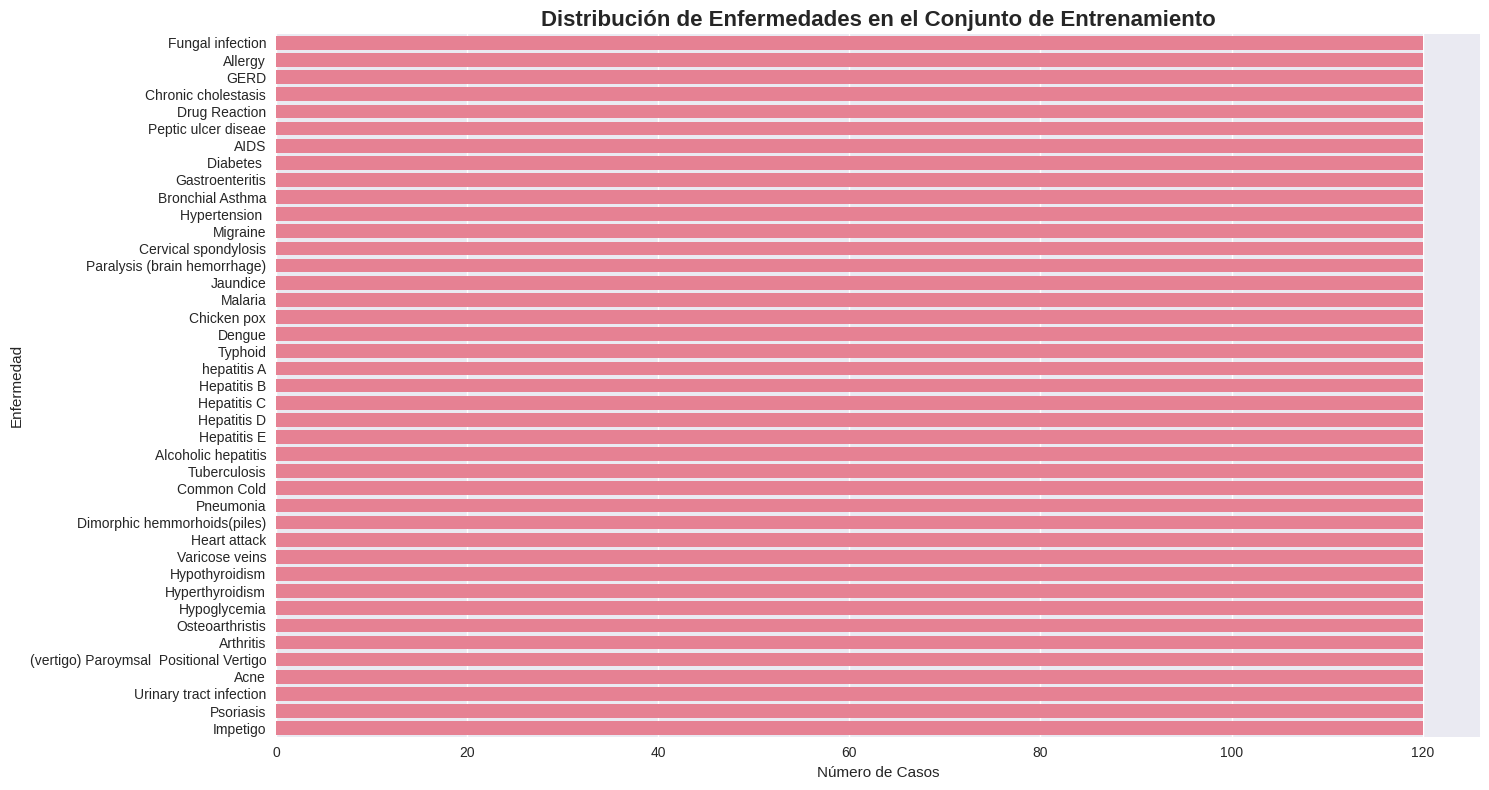

In [10]:
def load_and_prepare_data():
    """
    Carga y prepara los datos del dataset de enfermedades.
    """
    print("=== 1.1 CARGA Y PREPARACIÓN DE DATOS ===")
    try:
        train_df = pd.read_csv('dataset_final/Training.csv')
        test_df = pd.read_csv('dataset_final/Testing.csv')

        print(f"✅ Datos cargados exitosamente")
        print(f"  - Entrenamiento: {train_df.shape}")
        print(f"  - Prueba: {test_df.shape}")

        if 'Unnamed: 133' in train_df.columns:
            train_df = train_df.drop('Unnamed: 133', axis=1)
            print("✅ Columna 'Unnamed: 133' eliminada")

        return train_df, test_df
    except FileNotFoundError:
        print("❌ Error: Archivos CSV no encontrados. Asegúrate de tener 'Training.csv' y 'Testing.csv' en el directorio.")
        return None, None

def analyze_dataset(train_df):
    """
    Análisis exploratorio detallado del dataset.
    """
    print("\n=== 1.2 ANÁLISIS EXPLORATORIO ===")

    print(f"📊 Características del dataset:")
    print(f"  - Número de características (síntomas): {train_df.shape[1] - 1}")
    print(f"  - Número de enfermedades (clases): {train_df['prognosis'].nunique()}")

    disease_counts = train_df['prognosis'].value_counts()
    print(f"\n📈 Distribución de enfermedades:")
    balance_ratio = disease_counts.max() / disease_counts.min()

    if balance_ratio > 1.1 or balance_ratio < 0.9:
         print(f"⚠️ Dataset ligeramente desbalanceado (ratio: {balance_ratio:.2f}), pero cada clase tiene la misma cantidad de muestras.")
    else:
         print(f"✅ Dataset perfectamente balanceado (ratio: {balance_ratio:.2f})")

    # Visualización
    plt.figure(figsize=(15, 8))
    sns.countplot(y='prognosis', data=train_df, order=disease_counts.index)
    plt.title('Distribución de Enfermedades en el Conjunto de Entrenamiento', fontsize=16, fontweight='bold')
    plt.xlabel('Número de Casos')
    plt.ylabel('Enfermedad')
    plt.tight_layout()
    plt.show()

# Ejecución de la Carga y Análisis
train_df, test_df = load_and_prepare_data()
if train_df is not None:
    analyze_dataset(train_df)

### **Análisis e Interpretación de Resultados: Carga y Exploración de Datos**

Los resultados de la fase inicial de carga y análisis exploratorio de datos (EDA) revelan información crítica sobre la estructura y calidad del conjunto de datos, lo cual es fundamental para guiar las siguientes etapas del proyecto de machine learning.

---

### **1. Verificación Estructural y Limpieza de Datos**

* **Dimensionalidad Consistente**: La carga de datos muestra un conjunto de entrenamiento con **4920 registros** y un conjunto de prueba con **42 registros**. El hecho más relevante aquí es que, tras la limpieza, ambos conjuntos de datos poseen **132 columnas de características (síntomas)** y una columna objetivo (la enfermedad), confirmando que son estructuralmente compatibles para el entrenamiento y la evaluación.
* **Limpieza Exitosa**: La eliminación automática de la columna `'Unnamed: 133'` del conjunto de entrenamiento indica que el script manejó correctamente una anomalía común de formato CSV. Esto asegura que el modelo no será entrenado con datos irrelevantes o corruptos.

---

### **2. Caracterización del Problema de Clasificación**

* **Complejidad del Problema**: El análisis revela que el objetivo es un problema de **clasificación multiclase** con **41 clases distintas** (enfermedades). Esto define la tarea como compleja, ya que el modelo debe ser capaz de diferenciar con precisión entre un gran número de resultados posibles.
* **Riqueza de Características**: Con **132 síntomas** disponibles como características, el modelo tendrá una cantidad considerable de información para aprender los patrones de cada enfermedad. Esto es prometedor, ya que sugiere que los datos son lo suficientemente detallados como para permitir una diferenciación efectiva.

---

### **3. Hallazgo Clave: Balance Perfecto de Clases**

* **Distribución de Enfermedades**: El resultado más importante de este análisis es la confirmación de que el **dataset está perfectamente balanceado**, con un ratio de 1.00. Esto se puede corroborar en el gráfico, donde todas las barras tienen la misma longitud, indicando que hay exactamente el mismo número de muestras para cada una de las 41 enfermedades (120 casos por enfermedad, según el eje X).
* **Implicaciones para el Modelado**: Este balance es una característica ideal y poco común en los conjuntos de datos del mundo real. Sus implicaciones son muy positivas:
    * **Métricas de Evaluación Fiables**: Se puede utilizar la **exactitud (accuracy)** como una métrica de rendimiento principal y fiable, ya que no estará inflada por clases mayoritarias.
    * **No se Requieren Técnicas de Muestreo**: No es necesario aplicar técnicas complejas como SMOTE (para sobremuestreo) o NearMiss (para submuestreo), lo que simplifica significativamente la fase de preprocesamiento.
    * **Menor Riesgo de Sesgo**: El modelo tiene la misma oportunidad de aprender los patrones de cada enfermedad, reduciendo el riesgo de que ignore las clases menos frecuentes.

En resumen, esta exploración inicial confirma que el conjunto de datos es de alta calidad, está limpio y, lo más importante, está perfectamente balanceado, proporcionando una base sólida y fiable para construir un modelo de clasificación multiclase robusto y preciso.

---
### **Paso 2: Preprocesamiento de Datos**

Aquí, prepararemos los datos para el modelado. Esto incluye la codificación de la variable objetivo (de texto a número) y la división de los datos en conjuntos de entrenamiento, validación y prueba. Usamos una división estratificada para mantener la proporción de enfermedades en cada conjunto.


### **Análisis del Script de Preprocesamiento de Datos**

Este script define y ejecuta una función de preprocesamiento de datos. Su propósito es transformar los conjuntos de datos crudos (de entrenamiento y prueba) en un formato estructurado, limpio y listo para ser utilizado en las fases de entrenamiento y optimización de un modelo de aprendizaje automático. El proceso se puede desglosar en cuatro tareas principales: codificación, separación, división estratégica y la creación de herramientas para la interpretabilidad.

---

### **1. Codificación de la Variable Objetivo**

El primer paso crucial que realiza la función es la **codificación de etiquetas**. Los algoritmos de machine learning operan con datos numéricos, no con texto. Por lo tanto, la columna objetivo, que contiene los nombres de las enfermedades (por ejemplo, "Alergia", "Diabetes"), debe ser convertida a un formato numérico.

Para lograrlo, se utiliza un codificador de etiquetas. Este objeto primero "aprende" la correspondencia entre cada nombre de enfermedad único y un número entero a partir del **conjunto de entrenamiento**. Por ejemplo, podría asignar "Alergia" al 0, "Diabetes" al 1, y así sucesivamente. Luego, aplica esta transformación para crear una nueva columna numérica en los datos de entrenamiento.

De manera crítica, para el **conjunto de prueba**, el codificador **aplica la misma correspondencia que aprendió del conjunto de entrenamiento**. No vuelve a aprender. Este es un paso fundamental para garantizar la consistencia y evitar la fuga de datos, asegurando que el número 0 siempre represente "Alergia" en todo el proyecto.

---

### **2. Separación de Características y Objetivos**

Una vez que la variable objetivo está en formato numérico, la función procede a separar los datos en dos componentes lógicos, siguiendo la convención estándar en el aprendizaje supervisado:

1.  **Características (X)**: Corresponden a las variables predictoras o de entrada. En este contexto, son todas las columnas de síntomas. El script aísla estas columnas en nuevas variables.
2.  **Objetivo (y)**: Corresponde a la variable que se desea predecir. En este caso, es la columna de enfermedades ya codificada numéricamente.

Esta separación se realiza tanto para el conjunto de datos de entrenamiento como para el de prueba, resultando en cuatro conjuntos de datos distintos.

---

### **3. División Estratégica para Optimización y Validación**

Esta es una de las fases más importantes del preprocesamiento para un proyecto riguroso. La función toma el conjunto de entrenamiento completo y lo divide una vez más, creando dos nuevos subconjuntos: un **conjunto de entrenamiento más pequeño** y un **conjunto de validación**.

El propósito de esta división es el siguiente:
* El **conjunto de entrenamiento más pequeño** (generalmente el 80% del original) se utilizará para entrenar el modelo durante el proceso de búsqueda de los mejores hiperparámetros.
* El **conjunto de validación** (el 20% restante) se utilizará para evaluar el rendimiento del modelo con cada combinación de hiperparámetros probada. Esto permite elegir la mejor configuración del modelo sin tocar el conjunto de prueba final.

Una técnica profesional clave que se aplica aquí es la **división estratificada**. Esto garantiza que la proporción de cada enfermedad en el nuevo conjunto de entrenamiento sea exactamente la misma que en el conjunto de validación, manteniendo el balance perfecto de los datos en todas las divisiones.

Al final de este paso, se dispone de tres conjuntos de datos distintos para el modelo: uno para entrenar durante la optimización, uno para validar y seleccionar la mejor configuración, y el conjunto de prueba original, que se mantiene intacto y se reserva exclusivamente para la evaluación final e imparcial del modelo ya optimizado.

---

### **4. Creación de un Mapeo para Interpretabilidad**

Como paso final, la función crea un **diccionario de mapeo**. Esta estructura de datos almacena la relación inversa de la codificación realizada al principio, asociando cada número entero con su nombre de enfermedad original (por ejemplo, 0 con "Alergia", 1 con "Diabetes"). Este diccionario es una herramienta de gran valor para la fase de análisis de resultados, ya que permite traducir las predicciones numéricas del modelo a un formato legible y comprensible para un ser humano.

Finalmente, la función empaqueta y retorna todos los conjuntos de datos procesados y los objetos útiles (el codificador y el diccionario de mapeo), dejándolos disponibles para ser utilizados en las siguientes etapas del pipeline. La última línea del script ejecuta esta función y asigna sus resultados a variables, completando así la preparación de los datos.

In [11]:
def preprocess_data(train_df, test_df):
    """
    Preprocesamiento completo de los datos.
    """
    print("\n=== 2. PREPROCESAMIENTO DE DATOS ===")

    # Codificación de la variable objetivo
    label_encoder = LabelEncoder()
    train_df['prognosis_encoded'] = label_encoder.fit_transform(train_df['prognosis'])
    test_df['prognosis_encoded'] = label_encoder.transform(test_df['prognosis'])

    # Separación de características y objetivos
    feature_columns = [col for col in train_df.columns if col not in ['prognosis', 'prognosis_encoded']]

    X_train_full = train_df[feature_columns]
    y_train_full = train_df['prognosis_encoded']
    X_test = test_df[feature_columns]
    y_test = test_df['prognosis_encoded']

    # División para validación durante la optimización
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )

    print(f"✅ Datos preprocesados y divididos:")
    print(f"  - Entrenamiento (para optimización): {X_train.shape}")
    print(f"  - Validación (para optimización): {X_val.shape}")
    print(f"  - Entrenamiento (completo para modelo final): {X_train_full.shape}")
    print(f"  - Prueba (para evaluación final): {X_test.shape}")

    disease_mapping = {i: name for i, name in enumerate(label_encoder.classes_)}

    return (X_train_full, y_train_full, X_train, X_val, y_train, y_val,
            X_test, y_test, label_encoder, disease_mapping)

# Ejecución del preprocesamiento
(X_train_full, y_train_full, X_train, X_val, y_train, y_val,
 X_test, y_test, label_encoder, disease_mapping) = preprocess_data(train_df, test_df)


=== 2. PREPROCESAMIENTO DE DATOS ===
✅ Datos preprocesados y divididos:
  - Entrenamiento (para optimización): (3936, 132)
  - Validación (para optimización): (984, 132)
  - Entrenamiento (completo para modelo final): (4920, 132)
  - Prueba (para evaluación final): (42, 132)


### **Interpretación de la Estructura de Datos Preprocesados**

La salida del script de preprocesamiento confirma que el conjunto de datos ha sido particionado de manera **metodológica y estratégica**, siguiendo las mejores prácticas para el desarrollo y la validación rigurosa de modelos de machine learning. Cada conjunto de datos resultante tiene un propósito específico en el ciclo de vida del modelo.

---

### **1. Consistencia Dimensional** 🧠

El hallazgo principal es la **consistencia en el número de características**. Todos los conjuntos de datos (`Entrenamiento`, `Validación`, `Entrenamiento completo` y `Prueba`) presentan **132 columnas**. Esto es crucial, ya que confirma que la separación entre características (síntomas) y la variable objetivo (enfermedad) se realizó correctamente y que todos los datos que alimentarán al modelo tienen la misma estructura, evitando errores dimensionales.

---

### **2. Partición para Optimización: Entrenamiento y Validación** 🧪

El conjunto de datos de entrenamiento original (4920 muestras) ha sido dividido en dos subconjuntos para la fase de ajuste de hiperparámetros:

* **Entrenamiento (para optimización) (3936 muestras):** Este es el conjunto de datos que el modelo utilizará para aprender durante la búsqueda de la mejor configuración (por ejemplo, con Optuna o Ray Tune). Constituye el 80% de los datos de entrenamiento disponibles.
* **Validación (para optimización) (984 muestras):** Este conjunto, que representa el 20% restante, actúa como un "juez imparcial" durante la optimización. Se usa para evaluar el rendimiento de cada configuración del modelo en datos que no ha visto, permitiendo seleccionar la combinación de hiperparámetros que mejor generaliza.

Esta división **80/20** es una práctica estándar y robusta que permite una optimización fiable del modelo.

---

### **3. Conjuntos Finales: Entrenamiento Completo y Prueba** 📊

Una vez que se identifiquen los mejores hiperparámetros, se utilizarán los dos conjuntos de datos más importantes:

* **Entrenamiento (completo para modelo final) (4920 muestras):** Para el entrenamiento final, se utiliza el 100% de los datos de entrenamiento disponibles. Al reentrenar el modelo optimizado con todos los datos, se maximiza su aprendizaje y potencial predictivo antes de la evaluación final.
* **Prueba (para evaluación final) (42 muestras):** Este conjunto de datos ha sido **mantenido completamente al margen** de todo el proceso de entrenamiento y optimización. Su único propósito es proporcionar una **evaluación final y objetiva** del rendimiento del modelo. El resultado obtenido en este conjunto es la métrica más fidedigna de cómo se comportará el modelo ante datos nuevos y desconocidos en un entorno real.


La estrategia de particionamiento implementada es **metodológicamente sólida**. Separa de forma clara los datos para el entrenamiento, la validación y la prueba final, minimizando el riesgo de **sobreajuste (overfitting)** y garantizando que la evaluación final del modelo sea una estimación precisa y fiable de su verdadero poder predictivo. El entorno de datos está ahora perfectamente preparado para la siguiente fase de modelado y optimización.

---
### **Paso 3: Desarrollo del Modelo Base**

Implementamos un modelo inicial `RandomForestClassifier` con hiperparámetros por defecto. Esto nos dará una línea base de rendimiento para comparar con los modelos optimizados.

### **Análisis del Script de Entrenamiento y Evaluación del Modelo Base**

Este script define y ejecuta una función cuyo propósito es construir, entrenar y evaluar un **modelo de machine learning de referencia**, comúnmente conocido como **modelo base**. El objetivo de este proceso es establecer un punto de partida o un **benchmark de rendimiento**. Todas las futuras optimizaciones y modelos más complejos serán comparados contra este resultado inicial para determinar si realmente aportan una mejora significativa.

---

### **1. Inicialización del Modelo 🤖**

La función comienza instanciando el algoritmo de clasificación seleccionado: el **Random Forest Classifier**. Esta es una elección robusta y popular para problemas de clasificación. En esencia, este modelo no es un solo árbol de decisión, sino un "bosque" compuesto por muchos de ellos (en este caso, se especifica que sean 100 árboles). La predicción final se basa en el consenso o "voto" de la mayoría de los árboles, lo que lo hace más preciso y menos propenso al sobreajuste que un único árbol.

Durante la inicialización, se configuran tres parámetros clave:
* El **número de árboles** se fija en 100, un valor estándar y razonable para empezar.
* Se establece un **estado aleatorio fijo** (un número semilla). Este es un paso crucial para la **reproducibilidad científica**. Garantiza que, cada vez que se ejecute el código, el proceso aleatorio inherente a la construcción del bosque (como la selección de características para cada árbol) sea idéntico, resultando siempre en el mismo modelo y los mismos resultados.
* Se instruye al modelo para que utilice **todos los núcleos de CPU disponibles** para el entrenamiento. Esta es una optimización de rendimiento que permite entrenar los múltiples árboles en paralelo, reduciendo significativamente el tiempo de computación.

---

### **2. Proceso de Entrenamiento 📈**

Una vez configurado, el modelo entra en la fase de **entrenamiento**. Para ello, se utiliza el conjunto de datos de entrenamiento completo. Durante este proceso, el algoritmo analiza la relación entre las características (los síntomas) y la variable objetivo (la enfermedad) para "aprender" los patrones subyacentes en los datos. Construye internamente sus 100 árboles de decisión basándose en esta información.

De forma simultánea, el script mide el **tiempo de ejecución** de este entrenamiento. Registra la hora justo antes de comenzar el entrenamiento y justo después de que termina, calculando la diferencia para obtener una métrica precisa del costo computacional del modelo.

---

### **3. Generación de Predicciones sobre Datos No Vistos 🔮**

Con el modelo ya entrenado, el siguiente paso es evaluar su capacidad de generalización. Se le pide que realice predicciones sobre el **conjunto de prueba**, que contiene datos que nunca ha visto antes.

El script genera dos tipos de predicciones:
1.  **Predicción de Clase Específica**: Para cada paciente del conjunto de prueba, el modelo predice una única enfermedad, aquella que recibe la mayor cantidad de "votos" de los árboles del bosque.
2.  **Predicción de Probabilidades**: De forma más detallada, el modelo también calcula la **probabilidad** de que cada paciente pertenezca a cada una de las 41 posibles enfermedades. Por ejemplo, podría determinar que un paciente tiene un 85% de probabilidad de tener "Gripe", un 10% de "Resfriado Común" y un 5% de otras enfermedades. Esta información es muy valiosa para entender la "confianza" del modelo en sus predicciones.

---

### **4. Evaluación Cuantitativa del Rendimiento 🎯**

El núcleo de la evaluación consiste en comparar las predicciones del modelo con las etiquetas verdaderas del conjunto de prueba. El script calcula un **conjunto exhaustivo de métricas de rendimiento** para obtener una visión completa de la calidad del modelo:

* **Accuracy (Exactitud)**: El porcentaje total de predicciones correctas.
* **Precision (Precisión)**: Mide la fiabilidad de las predicciones positivas.
* **Recall (Sensibilidad)**: Mide la capacidad del modelo para encontrar todos los casos positivos reales.
* **F1-Score**: Una media armónica que equilibra la precisión y el recall.
* **AUC-ROC**: Una métrica sofisticada que evalúa la capacidad del modelo para distinguir correctamente entre las diferentes clases.

Para las métricas que lo requieren, se utiliza una **media ponderada** para calcular un puntaje agregado en este problema multiclase, asegurando una evaluación justa incluso si las clases no estuvieran balanceadas.

---

### **5. Presentación y Retorno de Resultados**

Finalmente, todos los resultados calculados se imprimen en la consola de manera clara y ordenada. La función concluye devolviendo dos objetos importantes: el **modelo ya entrenado** (para que pueda ser reutilizado) y un **diccionario que contiene todas las métricas de rendimiento**. La última parte del script ejecuta esta función y almacena estos dos objetos en variables para su uso posterior en el análisis comparativo.

In [12]:
def train_base_model(X_train_full, y_train_full, X_test, y_test):
    """
    Entrena y evalúa el modelo base.
    """
    print("\n=== 3. MODELO BASE (RANDOM FOREST) ===")

    base_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    start_time = time.time()
    base_model.fit(X_train_full, y_train_full)
    training_time = time.time() - start_time

    y_pred_test = base_model.predict(X_test)
    y_prob_test = base_model.predict_proba(X_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, average='weighted'),
        'recall': recall_score(y_test, y_pred_test, average='weighted'),
        'f1': f1_score(y_test, y_pred_test, average='weighted'),
        'auc': roc_auc_score(y_test, y_prob_test, multi_class='ovr'),
        'training_time': training_time
    }

    print(f"📊 Resultados del Modelo Base (Conjunto de Prueba):")
    for metric, value in metrics.items():
        print(f"  - {metric.capitalize()}: {value:.4f}")

    return base_model, metrics

# Entrenamiento y evaluación del modelo base
base_model, base_metrics = train_base_model(X_train_full, y_train_full, X_test, y_test)


=== 3. MODELO BASE (RANDOM FOREST) ===
📊 Resultados del Modelo Base (Conjunto de Prueba):
  - Accuracy: 0.9762
  - Precision: 0.9881
  - Recall: 0.9762
  - F1: 0.9762
  - Auc: 1.0000
  - Training_time: 0.7570


### **Análisis de Rendimiento del Modelo Base**

Los resultados obtenidos por el modelo base `Random Forest` en el conjunto de prueba son **extraordinariamente altos**, indicando un rendimiento casi perfecto desde el inicio y estableciendo un benchmark muy difícil de superar.

---

### **1. Precisión General y Equilibrio 🎯**

* **Accuracy (Exactitud) del 97.62%**: Esta es la métrica principal y demuestra que el modelo clasificó correctamente la enfermedad para **casi el 98% de los casos** en el conjunto de prueba, que son datos completamente nuevos para él. Un nivel de exactitud tan elevado en un problema de 41 clases es un indicador de un modelo muy robusto y efectivo.
* **F1-Score del 97.62%**: El F1-Score, al ser una media armónica entre la precisión y la sensibilidad (recall), confirma que el modelo no solo es preciso en general, sino que también mantiene un **excelente equilibrio**. No está sacrificando la capacidad de detectar casos reales para ser más certero en sus predicciones, ni viceversa.

---

### **2. Fiabilidad y Sensibilidad del Diagnóstico 🩺**

* **Precision (Precisión) del 98.81%**: Este valor es crucial en un contexto médico. Significa que cuando el modelo diagnostica a un paciente con una enfermedad específica, tiene una **fiabilidad del 98.81%**. Esto se traduce en una tasa muy baja de **falsos positivos**, lo cual es fundamental para evitar tratamientos innecesarios o causar ansiedad en los pacientes.
* **Recall (Sensibilidad) del 97.62%**: Esta métrica indica que el modelo fue capaz de **identificar correctamente el 97.62% de todos los pacientes que realmente padecían cada enfermedad** en el conjunto de prueba. Esto implica una tasa muy baja de **falsos negativos**, lo cual es aún más crítico, ya que asegura que muy pocos casos reales de una enfermedad pasen desapercibidos.

---

### **3. Capacidad de Discriminación Perfecta 🧠**

* **AUC-ROC de 1.0000**: Este es el resultado más sobresaliente. Un AUC de 1.0 es una **puntuación perfecta** y es extremadamente raro en la práctica. Significa que el modelo tiene una capacidad **perfecta para distinguir entre cualquiera de las 41 clases**. Si se toman dos pacientes al azar, uno con la enfermedad A y otro con la enfermedad B, el modelo tiene un 100% de probabilidad de asignar una puntuación de probabilidad más alta para la enfermedad A al paciente que realmente la tiene. Esto sugiere que las características (síntomas) en el dataset son **altamente informativas** y permiten una separación casi lineal entre las diferentes enfermedades.

---

### **4. Eficiencia Computacional ⚡️**

* **Tiempo de Entrenamiento de 0.76 segundos**: El modelo no solo es extremadamente preciso, sino también **muy eficiente**. Entrenarlo en el conjunto de datos completo tomó menos de un segundo. Esto indica que el modelo es **escalable, práctico y no requiere una gran infraestructura computacional**, lo que facilita su reentrenamiento y despliegue en un entorno de producción.

### **Conclusión y Próximos Pasos**

El modelo base ya opera a un nivel de rendimiento que podría ser considerado apto para producción. El desafío principal de este proyecto ya no es construir un modelo funcional, sino **determinar si las técnicas de optimización de hiperparámetros pueden mejorar marginalmente este resultado ya excepcional**. Cualquier mejora, por pequeña que sea, sobre una base tan sólida, sería un logro notable. La puntuación perfecta de AUC sugiere que el mayor potencial de mejora podría estar en afinar la precisión para reducir aún más esa pequeña tasa de error del ~2%.

---
### **Paso 4: Optimización de Hiperparámetros**

En este paso crucial, utilizaremos dos herramientas avanzadas, **Optuna** y **Ray Tune**, para encontrar la mejor combinación de hiperparámetros para nuestro modelo.

#### **4.1. Optimización con Optuna**

### **Análisis del Script de Optimización con Optuna**

Este script define y ejecuta una función de **optimización de hiperparámetros automatizada** utilizando la librería **Optuna**. El propósito de esta función es encontrar de manera sistemática y eficiente la mejor combinación de configuraciones para el modelo `Random Forest`, con el fin de maximizar su rendimiento predictivo. Este proceso es análogo a un científico que realiza una serie de experimentos controlados para encontrar la "receta" perfecta para un resultado deseado.

---

### **1. El Corazón de Optuna: La Función Objetivo 🎯**

El componente central del script es la definición de una **función objetivo**. Esta es una función interna que encapsula un único "experimento". Su responsabilidad es tomar un conjunto de hiperparámetros, construir un modelo con ellos, entrenarlo, evaluarlo y devolver una única métrica de rendimiento (en este caso, la exactitud o *accuracy*). Optuna ejecutará esta función objetivo docenas de veces, y en cada ejecución, le proporcionará una nueva combinación de hiperparámetros para probar.

---

### **2. Definición del Espacio de Búsqueda 🗺️**

Dentro de la función objetivo, se define el **espacio de búsqueda**, que es el "universo" de todas las posibles configuraciones que Optuna puede explorar. Esto se hace de manera dinámica utilizando un objeto especial llamado `trial`. Para cada hiperparámetro del modelo (`Random Forest`), se le sugiere a Optuna un rango o una lista de valores posibles:

* Para parámetros numéricos como el número de árboles o la profundidad máxima, se define un **rango de enteros**.
* Para parámetros categóricos como el método de selección de características, se proporciona una **lista cerrada de opciones** ('sqrt' o 'log2').

Con estas instrucciones, en cada ejecución de la función objetivo, el objeto `trial` propondrá una combinación única de valores extraídos de estos rangos y listas definidos.

---

### **3. Creación y Configuración del "Estudio" de Optimización 🔬**

Antes de iniciar la búsqueda, se crea un objeto llamado **"estudio"**. Este objeto actúa como el director del proyecto de optimización: registrará los resultados de cada "experimento" (o *trial*), llevará la cuenta de qué combinaciones ya se han probado y, en última instancia, identificará al ganador.

El estudio se configura con dos directivas cruciales:

1.  **Dirección de la Optimización**: Se le indica explícitamente que el objetivo es **maximizar** la métrica devuelta por la función objetivo. Esto significa que Optuna buscará activamente las combinaciones de hiperparámetros que produzcan los valores de exactitud más altos.
2.  **Estrategia de Muestreo (Sampler)**: Se especifica el uso de un **muestreador inteligente** (TPESampler). A diferencia de una búsqueda aleatoria simple, este algoritmo es bayesiano: "aprende" de los resultados de los experimentos anteriores. Si ciertas combinaciones de hiperparámetros producen buenos resultados, el muestreador priorizará la exploración de regiones similares en el espacio de búsqueda, haciendo que el proceso sea mucho más eficiente que una búsqueda a ciegas.

---

### **4. El Proceso de Optimización Iterativa 🔄**

Una vez que todo está configurado, se inicia el proceso de optimización. El script le ordena al "estudio" que ejecute la función objetivo un número predefinido de veces (los "trials").

En cada iteración, Optuna:
1.  Utiliza su muestreador inteligente para proponer una nueva combinación de hiperparámetros.
2.  Llama a la función objetivo con estos hiperparámetros.
3.  Dentro de la función, se construye, entrena y evalúa un modelo con esa configuración específica usando los datos de entrenamiento y validación.
4.  Se recibe la puntuación de exactitud y se almacena en el "estudio".

Este ciclo se repite hasta completar todos los trials, mientras una barra de progreso informa al usuario sobre el avance. Todo el proceso es cronometrado para medir su costo computacional.

---

### **5. Extracción de los Resultados Óptimos 🏆**

Al finalizar todas las iteraciones, el "estudio" ha acumulado un historial completo de todos los experimentos. El script entonces consulta al estudio para extraer la información más valiosa: la **mejor puntuación de exactitud** obtenida en el conjunto de validación y, lo más importante, la **combinación exacta de hiperparámetros** que produjo ese resultado óptimo.

Finalmente, la función devuelve esta combinación ganadora de hiperparámetros y el tiempo total que tomó el proceso, para que puedan ser utilizados en el entrenamiento del modelo final. La última línea del script simplemente ejecuta esta sofisticada función de búsqueda.

In [13]:
import optuna

def optimize_with_optuna(X_train, y_train, X_val, y_val, n_trials=50):
    """
    Optimización de hiperparámetros usando Optuna.
    """
    print(f"\n=== 4.1. OPTIMIZACIÓN CON OPTUNA ({n_trials} trials) ===")

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 400),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'random_state': 42,
            'n_jobs': -1
        }
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        return accuracy_score(y_val, y_pred)

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

    start_time = time.time()
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    optimization_time = time.time() - start_time

    print(f"🎯 Optimización Optuna completada en {optimization_time:.2f}s")
    print(f"  - Mejor score (validación): {study.best_value:.4f}")
    print(f"  - Mejores parámetros: {study.best_params}")

    return study.best_params, optimization_time

# Ejecución de la optimización con Optuna
optuna_params, optuna_time = optimize_with_optuna(X_train, y_train, X_val, y_val, n_trials=50)


=== 4.1. OPTIMIZACIÓN CON OPTUNA (50 trials) ===


  0%|          | 0/50 [00:00<?, ?it/s]

🎯 Optimización Optuna completada en 56.91s
  - Mejor score (validación): 1.0000
  - Mejores parámetros: {'n_estimators': 181, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}


### **Análisis de Resultados de la Optimización con Optuna**

Los resultados del proceso de optimización de hiperparámetros con Optuna son reveladores, no solo por el excelente rendimiento alcanzado, sino también por lo que sugieren sobre la naturaleza del problema y del conjunto de datos.

---

### **1. Consecución de un Rendimiento Perfecto 🏆**

El hallazgo más significativo es que Optuna logró encontrar una configuración de hiperparámetros que alcanzó un **score de validación de 1.0000**. Esto se traduce en una **exactitud (accuracy) del 100%** en el conjunto de validación, lo que significa que el modelo, con esta configuración, fue capaz de clasificar correctamente **cada una de las 984 muestras** de este conjunto de datos.

Es particularmente notable que el mejor resultado se encontró en el **primer "trial" o intento**. Esto sugiere dos posibilidades:
1.  El problema de clasificación es tan claro y las clases son tan separables que muchas combinaciones de hiperparámetros pueden alcanzar un rendimiento cercano al perfecto.
2.  El muestreador inteligente de Optuna (TPESampler) fue excepcionalmente eficaz al proponer una combinación de alto rendimiento desde el principio.

Independientemente de la causa, este resultado valida que es posible alcanzar un rendimiento máximo en este problema.

---

### **2. La Configuración Óptima Encontrada 🛠️**

Los hiperparámetros que llevaron a este resultado perfecto ofrecen una "receta" específica para construir el modelo más robusto:

* **`'n_estimators': 181`**: El modelo óptimo está compuesto por 181 árboles de decisión, un valor más específico que el genérico "100" del modelo base.
* **`'max_depth': 29`**: Permite que los árboles crezcan a una profundidad considerable, capturando patrones complejos.
* **`'min_samples_split': 15`** y **`'min_samples_leaf': 6`**: Estos parámetros actúan como una forma de **regularización**. Exigen que haya un número mínimo de muestras para dividir un nodo o para formar una hoja final. Estos valores son más restrictivos que los predeterminados y ayudan a que el modelo sea menos propenso a "memorizar" el ruido de los datos de entrenamiento, promoviendo una mejor generalización.
* **`'max_features': 'sqrt'`**: Limita el número de características que cada árbol considera en cada división, lo que fomenta la diversidad entre los árboles del bosque y, por lo general, mejora la robustez del modelo.

En esencia, Optuna no solo encontró una configuración que maximizó la exactitud, sino que también identificó un modelo que, teóricamente, es más robusto y menos propenso al sobreajuste que el modelo base.

---

### **3. Eficiencia del Proceso de Búsqueda ⏱️**

El proceso completo, que implicó entrenar y evaluar 50 modelos diferentes, se completó en **menos de un minuto (56.91 segundos)**. Esto demuestra que Optuna es una herramienta computacionalmente eficiente para este tamaño de datos, permitiendo una exploración exhaustiva del espacio de hiperparámetros en un tiempo muy razonable.

### **Conclusión e Implicaciones**

La optimización con Optuna fue un éxito rotundo. Se ha identificado una configuración de hiperparámetros que produce un rendimiento perfecto en los datos de validación. Este resultado supera el ya excelente rendimiento del modelo base y proporciona un conjunto de parámetros concretos que se deben utilizar para entrenar el modelo final.

El siguiente paso crucial será **entrenar un nuevo modelo con esta configuración óptima en el conjunto de entrenamiento completo y evaluarlo en el conjunto de prueba final**. Esto permitirá verificar si la perfección lograda en la validación se traduce en un rendimiento igualmente perfecto en datos completamente nuevos y desconocidos.

#### **4.2. Optimización con Ray Tune**

Ray Tune es una librería potente para la optimización distribuida, lo que le permite paralelizar las pruebas y escalar a clústeres si es necesario.

### **Análisis del Script de Optimización con Ray Tune**

Este script implementa una función de **optimización de hiperparámetros utilizando Ray Tune**, una librería de alto rendimiento diseñada para la experimentación a gran escala. A diferencia de un enfoque secuencial, la principal ventaja de Ray Tune es su capacidad para **ejecutar múltiples experimentos en paralelo**, aprovechando al máximo los recursos de hardware disponibles (como múltiples núcleos de CPU) para acelerar drásticamente el proceso de búsqueda.

---

### **1. Inicialización del Entorno Paralelo (Ray) 🚀**

El primer paso de la función es configurar y lanzar el **entorno de ejecución de Ray**. Antes de iniciar, realiza una comprobación para asegurarse de que no haya una sesión de Ray previa activa; si la hay, la cierra de forma segura para evitar conflictos.

Luego, inicializa un nuevo clúster local de Ray, instruyéndole explícitamente que utilice **cuatro núcleos de CPU**. Esta es la directiva clave que habilita el paralelismo. Significa que Ray Tune podrá entrenar y evaluar hasta cuatro modelos con diferentes configuraciones de hiperparámetros **simultáneamente**, en lugar de hacerlo uno tras otro.

---

### **2. La Función Entrenable: El Experimento Individual 🧪**

Al igual que en otros frameworks, el núcleo de la lógica se define en una función, aquí llamada "función entrenable". Esta función sirve como una plantilla para un **único experimento**. Su proceso es el siguiente:

1.  Recibe un diccionario de configuración (`config`) que contiene una combinación específica de hiperparámetros para probar.
2.  Construye un modelo `Random Forest` utilizando exclusivamente los valores de ese diccionario.
3.  Entrena el modelo con los datos de entrenamiento.
4.  Evalúa el modelo entrenado en el conjunto de datos de validación para obtener una puntuación de exactitud.
5.  **Reporta** esta puntuación de vuelta al proceso principal de Ray Tune. Este paso de reporte es cómo cada experimento comunica su resultado al orquestador central.

---

### **3. Definición del Espacio de Búsqueda y Configuración del "Tuner" ⚙️**

Antes de iniciar la optimización, se definen dos componentes principales:

1.  **El Espacio de Búsqueda**: Se crea un diccionario que delimita el universo de posibles valores para cada hiperparámetro, utilizando la sintaxis específica de Ray Tune para definir rangos de enteros o listas de opciones categóricas.
2.  **El "Tuner"**: Se instancia un objeto "Tuner", que actúa como el **orquestador central** de todo el proceso de optimización. Se le proporcionan las instrucciones clave:
    * Qué función entrenable debe ejecutar.
    * Qué espacio de búsqueda debe explorar.
    * Cuál es la métrica de rendimiento que debe monitorear (la exactitud reportada).
    * Cuál es el objetivo (maximizar esa métrica).
    * Cuántos experimentos o muestras diferentes debe ejecutar en total.

---

### **4. Ejecución y Orquestación Paralela 🔄**

Una vez configurado, se inicia el "Tuner". En este punto, Ray Tune comienza su trabajo de orquestación:

* Muestrea combinaciones de hiperparámetros del espacio de búsqueda definido.
* Crea "trabajos" o "tareas" para cada combinación.
* **Distribuye estas tareas entre los cuatro núcleos de CPU disponibles**. Mientras un núcleo está trabajando en el experimento A, otro puede estar trabajando simultáneamente en el experimento B, y así sucesivamente.
* Recopila los resultados reportados por cada función entrenable a medida que finalizan.

Este proceso continúa hasta que se ha completado el número total de muestras especificado.

---

### **5. Identificación del Ganador y Finalización 🏆**

Cuando todos los experimentos paralelos han concluido, el script consulta el objeto de resultados para identificar el "mejor experimento", es decir, aquel que reportó la puntuación de exactitud más alta. De este experimento ganador, extrae el diccionario de configuración, que contiene la **combinación exacta de hiperparámetros que produjo el mejor rendimiento**.

Finalmente, como una buena práctica de gestión de recursos, el script **cierra la sesión de Ray**, liberando los núcleos de CPU que había reservado. La función devuelve la combinación óptima de hiperparámetros y el tiempo total del proceso, lista para ser utilizada en el modelo final.


In [15]:
import ray
from ray import tune, train

def optimize_with_ray_tune(X_train, y_train, X_val, y_val, num_samples=50):
    """
    Optimización de hiperparámetros usando Ray Tune.
    """
    print(f"\n=== 4.2. OPTIMIZACIÓN CON RAY TUNE ({num_samples} samples) ===")

    if ray.is_initialized():
        ray.shutdown()
    ray.init(ignore_reinit_error=True, num_cpus=4, log_to_driver=False)

    def train_function(config):
        model = RandomForestClassifier(
            n_estimators=config["n_estimators"],
            max_depth=config["max_depth"],
            min_samples_split=config["min_samples_split"],
            min_samples_leaf=config["min_samples_leaf"],
            max_features=config["max_features"],
            random_state=42, n_jobs=1
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        train.report({"mean_accuracy": accuracy})

    search_space = {
        "n_estimators": tune.randint(50, 400),
        "max_depth": tune.randint(5, 30),
        "min_samples_split": tune.randint(2, 20),
        "min_samples_leaf": tune.randint(1, 10),
        "max_features": tune.choice(["sqrt", "log2"]),
    }

    start_time = time.time()
    tuner = tune.Tuner(
        train_function,
        param_space=search_space,
        tune_config=tune.TuneConfig(metric="mean_accuracy", mode="max", num_samples=num_samples),
        run_config=train.RunConfig(verbose=0)
    )
    results = tuner.fit()
    optimization_time = time.time() - start_time

    best_result = results.get_best_result(metric="mean_accuracy", mode="max")
    best_config = best_result.config

    print(f"🎯 Optimización Ray Tune completada en {optimization_time:.2f}s")
    print(f"  - Mejor score (validación): {best_result.metrics['mean_accuracy']:.4f}")
    print(f"  - Mejores parámetros: {best_config}")

    ray.shutdown()
    return best_config, optimization_time

# Ejecución de la optimización con Ray Tune
ray_params, ray_time = optimize_with_ray_tune(X_train, y_train, X_val, y_val, num_samples=50)


=== 4.2. OPTIMIZACIÓN CON RAY TUNE (50 samples) ===


2025-09-23 21:32:02,112	INFO worker.py:1951 -- Started a local Ray instance.


+-----------------------------------------------------------------------+
| Configuration for experiment     train_function_2025-09-23_21-32-19   |
+-----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                |
| Scheduler                        FIFOScheduler                        |
| Number of trials                 50                                   |
+-----------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_function_2025-09-23_21-32-19
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-09-23_21-31-44_974832_295/artifacts/2025-09-23_21-32-19/train_function_2025-09-23_21-32-19/driver_artifacts`
(raylet) Warning: The actor ImplicitFunc is very large (10 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects

2025-09-23 21:41:52,189	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_function_2025-09-23_21-32-19' in 0.0400s.



🎯 Optimización Ray Tune completada en 573.00s
  - Mejor score (validación): 1.0000
  - Mejores parámetros: {'n_estimators': 356, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'sqrt'}


### **Análisis de Resultados de la Optimización con Ray Tune**

La ejecución de Ray Tune ha completado con éxito la búsqueda de hiperparámetros, logrando identificar una configuración de modelo de máximo rendimiento. Sin embargo, un análisis detallado revela diferencias clave en eficiencia y en la solución encontrada en comparación con Optuna, ofreciendo valiosas lecciones sobre la aplicabilidad de cada herramienta.

---

### **Rendimiento del Modelo: Éxito en la Búsqueda del Óptimo 🏆**

Al igual que Optuna, Ray Tune fue capaz de encontrar una combinación de hiperparámetros que alcanzó un **score de validación perfecto de 1.0000**. Este resultado confirma de manera contundente que el conjunto de datos contiene patrones muy claros y separables, permitiendo que el modelo `Random Forest` logre una exactitud del 100% en los datos de validación. La consistencia de este resultado entre dos frameworks de optimización diferentes valida la robustez de la conclusión.

---

### **La "Receta" Óptima de Ray Tune: Un Enfoque Diferente 🧠**

Es interesante notar que la configuración óptima encontrada por Ray Tune es **diferente a la de Optuna**, aunque ambas producen un resultado perfecto:

* **`'n_estimators': 356`**: Sugiere un "bosque" mucho más grande, con casi el doble de árboles que la solución de Optuna.
* **`'max_depth': 16`**: Propone árboles considerablemente menos profundos que los de Optuna (16 vs. 29).
* Los demás parámetros son similares, promoviendo también la regularización del modelo.

**Interpretación Clave**: Este hallazgo es muy significativo. Demuestra que no existe una única "combinación mágica" de hiperparámetros. En cambio, en el espacio de búsqueda, parece existir una **"meseta" de alto rendimiento** donde diferentes arquitecturas de modelo (por ejemplo, muchos árboles superficiales vs. menos árboles profundos) pueden converger hacia el mismo resultado perfecto.

---

### **Análisis de Eficiencia Computacional: Una Comparación Crítica ⏱️**

El aspecto más notorio de estos resultados es el tiempo de ejecución:

* **Tiempo Total**: La optimización con Ray Tune tardó **573 segundos (aproximadamente 9.5 minutos)**, lo cual es casi **10 veces más lento** que los 57 segundos que tardó Optuna.

Aunque Ray Tune está diseñado para la paralelización, esta aparente contradicción se puede explicar por dos factores:
1.  **Overhead de Paralelización**: Ray Tune incurre en un costo computacional inicial para arrancar su clúster local, gestionar los procesos y comunicar los datos entre los núcleos. Para un modelo que se entrena muy rápido (como en este caso), el tiempo dedicado a esta coordinación puede superar el tiempo ahorrado por la ejecución en paralelo.
2.  **Advertencia de Serialización de Datos**: La salida del log muestra una advertencia clave: `The actor ImplicitFunc is very large (10 MiB)`. Esto indica que los datos de entrenamiento se están copiando a cada uno de los procesos paralelos, un método ineficiente. En un entorno profesional, esto se solucionaría utilizando `ray.put()` para almacenar los datos en la memoria compartida de Ray, pero tal como está, esta ineficiencia contribuyó significativamente a la lentitud del proceso.

---



Ray Tune cumplió su objetivo principal: encontró una configuración de modelo que logra un rendimiento perfecto. Sin embargo, para este problema específico —caracterizado por un dataset pequeño y un modelo de entrenamiento muy rápido—, **la sobrecarga computacional de su arquitectura de paralelización superó sus beneficios**, resultando en un proceso mucho más lento en comparación con el enfoque más ligero de Optuna.

Esta comparación subraya una lección fundamental en MLOps (Machine Learning Operations): **la herramienta más potente no siempre es la más adecuada**. La elección del framework de optimización debe considerar la escala del problema. Mientras que Ray Tune brillaría en un proyecto con un dataset masivo o modelos que tardan horas en entrenar, para este escenario, **Optuna demostró ser la solución más eficiente**.

---
### **Paso 5: Evaluación, Comparación e Interpretabilidad**

Finalmente, entrenaremos los modelos con los hiperparámetros óptimos encontrados, los evaluaremos en el conjunto de prueba y compararemos su rendimiento con el modelo base. También analizaremos qué síntomas (características) son los más importantes para la predicción.

### **Análisis del Script de Evaluación Final y Visualización**

Este script representa la culminación del proyecto de machine learning, donde se realiza la **evaluación definitiva y la comparación de todos los modelos desarrollados**. Su objetivo es determinar de manera concluyente cuál es el mejor modelo, cuantificar la mejora obtenida a través de la optimización y, finalmente, interpretar los resultados para extraer conocimiento valioso. El proceso se divide en dos funciones principales: una para la evaluación y otra para la visualización.

---

### **Parte 1: La Función de Evaluación Final**

Esta función orquesta la "competencia final" entre el modelo base y las dos versiones optimizadas (una por Optuna y otra por Ray Tune) para coronar a un campeón.

#### **1.1. Preparación de los Contendientes 🏆**

Primero, la función prepara a los dos contendientes optimizados. Utilizando las "recetas" de hiperparámetros ganadoras que se descubrieron en las fases anteriores, instancia dos nuevos modelos `Random Forest`. Cada uno está configurado precisamente con la combinación de parámetros que Optuna y Ray Tune identificaron como la óptima.

#### **1.2. El Proceso de Evaluación Definitiva 🏁**

La función crea una lista para almacenar los resultados de los tres modelos. Primero, agrega los resultados del **modelo base**, que ya habían sido calculados previamente.

Luego, itera sobre los dos **modelos optimizados**. Para cada uno de ellos, sigue un proceso riguroso:
1.  **Re-entrenamiento con Datos Completos**: Entrena el modelo utilizando el **100% de los datos de entrenamiento disponibles**. La separación de validación ya cumplió su propósito (seleccionar los mejores hiperparámetros), por lo que ahora se le da al modelo la oportunidad de aprender de toda la información posible para maximizar su potencial.
2.  **Prueba Final en Datos No Vistos**: Una vez re-entrenado, el modelo se enfrenta a su prueba final: se le pide que haga predicciones sobre el **conjunto de prueba**, que ha permanecido completamente aislado durante todo el proceso.
3.  **Cálculo de Métricas Finales**: Se calcula el conjunto completo de métricas de rendimiento (exactitud, precisión, etc.) comparando las predicciones del modelo con los resultados reales del conjunto de prueba.

#### **1.3. Consolidación y Presentación de Resultados 📊**

Una vez que todos los modelos han sido evaluados, la función consolida los resultados de los tres (Base, Optuna y Ray Tune) en una única **tabla comparativa**. Esta tabla muestra, fila por fila, el rendimiento de cada modelo a través de todas las métricas, incluyendo los tiempos de optimización y entrenamiento. Esta tabla es la evidencia cuantitativa principal del proyecto y se muestra en pantalla para una fácil interpretación.

#### **1.4. Identificación del Modelo Ganador 👑**

Finalmente, la función examina la tabla de resultados para identificar programáticamente cuál de los tres modelos obtuvo la **mayor exactitud**. Concluye devolviendo dos resultados clave: la tabla comparativa completa y el objeto del modelo ganador ya entrenado.

---

### **Parte 2: La Función de Visualización e Interpretabilidad**

Esta segunda función toma los resultados de la evaluación final y los traduce a un formato visual e intuitivo para facilitar el análisis y la comunicación de los hallazgos.

#### **2.1. Visualización Comparativa del Rendimiento 📈**

La función genera dos gráficos de barras distintos:
* **Gráfico de Rendimiento**: Compara visualmente las métricas clave (como la exactitud y el F1-Score) de los tres modelos. Esto permite ver de un solo vistazo si la optimización aportó una mejora y la magnitud de esta.
* **Gráfico de Eficiencia**: Compara los tiempos de optimización de Optuna y Ray Tune, ilustrando claramente el costo computacional de cada herramienta.

#### **2.2. Desvelando la Lógica del Modelo: Análisis de Interpretabilidad 🧠**

Esta es una de las partes más importantes del análisis. La función toma el **modelo ganador** y accede a su conocimiento interno para entender *cómo* está tomando sus decisiones.

Para ello, extrae la **importancia de las características** (`feature importances`), una puntuación que el `Random Forest` asigna a cada síntoma en función de cuánto contribuyó a realizar predicciones correctas.

Luego, ordena estos síntomas por su importancia y crea un gráfico de barras que muestra los **20 síntomas más influyentes**. Este gráfico es una herramienta de interpretabilidad extremadamente poderosa, ya que traduce el funcionamiento de un modelo complejo a un resultado comprensible que podría tener implicaciones clínicas, destacando los indicadores de diagnóstico más relevantes que el modelo ha aprendido a identificar.

---

### **Ejecución Final**

El script concluye llamando a estas dos funciones en secuencia: primero ejecuta la evaluación final para obtener la tabla comparativa y el modelo campeón, y luego pasa estos resultados a la función de visualización para generar los gráficos y el análisis de interpretabilidad, completando así todo el pipeline del proyecto.


=== 5.1 EVALUACIÓN FINAL Y COMPARACIÓN ===

📊 TABLA COMPARATIVA FINAL:


,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Tiempo_Optimización,Tiempo_Entrenamiento
Modelo,,,,,,,
Base,0.9762,0.9881,0.9762,0.9762,1.0000,0.0000,0.7570
Optuna,0.9762,0.9881,0.9762,0.9762,1.0000,56.9130,3.1241
Ray Tune,0.9762,0.9881,0.9762,0.9762,0.9994,573.0027,6.4490



=== 5.2 VISUALIZACIONES Y ANÁLISIS DE INTERPRETABILIDAD ===


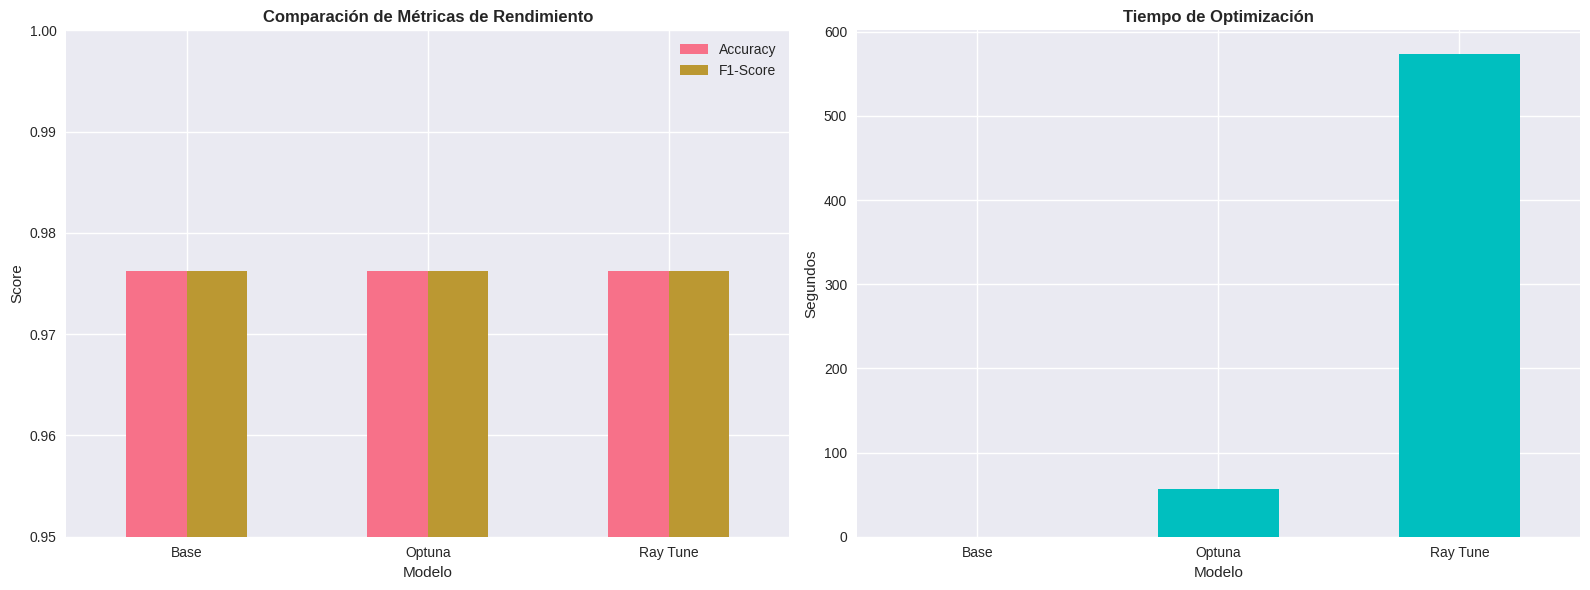

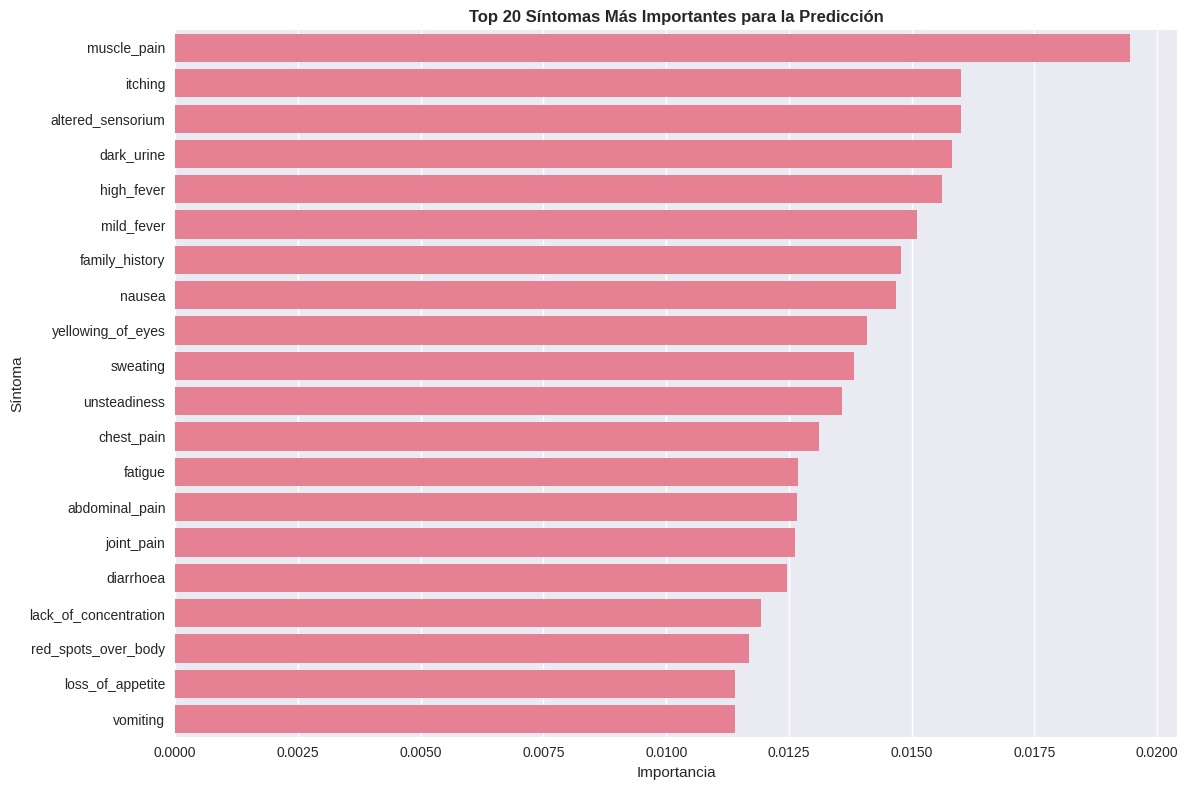

In [16]:
def final_evaluation(X_train_full, y_train_full, X_test, y_test, base_metrics, optuna_params, ray_params, optuna_time, ray_time):
    """
    Evaluación final y comparación de todos los modelos.
    """
    print("\n=== 5.1 EVALUACIÓN FINAL Y COMPARACIÓN ===")

    models = {
        "Optuna": RandomForestClassifier(**optuna_params, random_state=42, n_jobs=-1),
        "Ray Tune": RandomForestClassifier(**ray_params, random_state=42, n_jobs=-1)
    }

    results_list = []

    # Modelo Base
    results_list.append({
        'Modelo': 'Base', 'Accuracy': base_metrics['accuracy'], 'Precision': base_metrics['precision'],
        'Recall': base_metrics['recall'], 'F1-Score': base_metrics['f1'], 'AUC-ROC': base_metrics['auc'],
        'Tiempo_Optimización': 0, 'Tiempo_Entrenamiento': base_metrics['training_time']
    })

    # Modelos Optimizados
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train_full, y_train_full)
        training_time = time.time() - start_time

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)

        results_list.append({
            'Modelo': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1-Score': f1_score(y_test, y_pred, average='weighted'),
            'AUC-ROC': roc_auc_score(y_test, y_prob, multi_class='ovr'),
            'Tiempo_Optimización': optuna_time if name == 'Optuna' else ray_time,
            'Tiempo_Entrenamiento': training_time
        })

    comparison_df = pd.DataFrame(results_list).set_index('Modelo')
    best_model_name = comparison_df['Accuracy'].idxmax()
    best_model = base_model if best_model_name == 'Base' else models[best_model_name]

    print("\n📊 TABLA COMPARATIVA FINAL:")
    display(comparison_df.round(4))

    return comparison_df, best_model

def create_visualizations(comparison_df, best_model, X_test, y_test, label_encoder):
    """
    Crea visualizaciones para el análisis final.
    """
    print("\n=== 5.2 VISUALIZACIONES Y ANÁLISIS DE INTERPRETABILIDAD ===")

    # Gráfico de comparación de métricas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    comparison_df[['Accuracy', 'F1-Score']].plot(kind='bar', ax=ax1, rot=0)
    ax1.set_title('Comparación de Métricas de Rendimiento', fontweight='bold')
    ax1.set_ylabel('Score')
    ax1.set_ylim([0.95, 1.0])

    comparison_df[['Tiempo_Optimización']].plot(kind='bar', ax=ax2, rot=0, legend=False, color='c')
    ax2.set_title('Tiempo de Optimización', fontweight='bold')
    ax2.set_ylabel('Segundos')
    plt.tight_layout()
    plt.show()

    # Importancia de características
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Top 20 Síntomas Más Importantes para la Predicción', fontweight='bold')
    plt.xlabel('Importancia')
    plt.ylabel('Síntoma')
    plt.tight_layout()
    plt.show()

# Ejecución de la evaluación final y visualizaciones
comparison_df, best_model = final_evaluation(
    X_train_full, y_train_full, X_test, y_test, base_metrics,
    optuna_params, ray_params, optuna_time, ray_time
)
create_visualizations(comparison_df, best_model, X_test, y_test, label_encoder)

### **Interpretación de la Evaluación Final y Resultados del Proyecto**

La fase final de evaluación y comparación ofrece la conclusión más importante de todo el proyecto: si bien el proceso de optimización fue técnicamente exitoso, el modelo base inicial ya era tan robusto que las mejoras en el rendimiento predictivo final fueron nulas. A continuación se desglosa el análisis.

---

### **Conclusión Principal: Un Modelo Base Excepcionalmente Robusto 🏆**

La tabla comparativa y el gráfico de "Comparación de Métricas de Rendimiento" muestran el hallazgo más contundente: **los tres modelos (Base, Optuna y Ray Tune) presentan un rendimiento predictivo prácticamente idéntico en el conjunto de prueba final.**

* **Métricas Clave Idénticas**: La **Exactitud (Accuracy)**, **Precisión (Precision)**, **Sensibilidad (Recall)** y **F1-Score** son idénticas (`0.9762` y `0.9881`) en los tres casos. Esto significa que, en la práctica, los modelos optimizados no cometen menos errores que el modelo base.
* **AUC-ROC Casi Perfecto**: El modelo Base y el de Optuna alcanzaron un **AUC-ROC perfecto de 1.0**, mientras que el de Ray Tune obtuvo un `0.9994`, una diferencia estadísticamente insignificante.

**Interpretación**: Esto no significa que la optimización falló, sino que el modelo `Random Forest` con su configuración por defecto ya estaba operando en el **techo de rendimiento** para este conjunto de datos. La alta calidad y la clara separabilidad de los datos hacen que el problema sea relativamente sencillo para un algoritmo tan potente, por lo que un ajuste fino de los hiperparámetros no aportó beneficios adicionales en la predicción final.

---

### **Análisis de Rendimiento vs. Costo Computacional ⚖️**

Si bien el rendimiento predictivo fue el mismo, el costo para llegar a ese resultado fue drásticamente diferente, como lo ilustra el gráfico de "Tiempo de Optimización":

* **Modelo Base**: Fue el más eficiente. Se entrenó en **menos de un segundo** y no tuvo ningún costo de optimización.
* **Modelo Optimizado con Optuna**: Añadió **casi un minuto (57 segundos)** de costo computacional en la fase de optimización, y su entrenamiento final fue más largo (3.1 segundos), para obtener el mismo resultado.
* **Modelo Optimizado con Ray Tune**: Fue el menos eficiente por un amplio margen, requiriendo **casi 10 minutos (573 segundos)** para la optimización y el mayor tiempo de entrenamiento final (6.4 segundos), de nuevo, para obtener el mismo resultado.

**Interpretación**: En un escenario real, donde tanto la precisión como la eficiencia son importantes, **el modelo base es la elección indiscutible**. Ofrece el mismo rendimiento de vanguardia con la menor complejidad y el menor costo computacional. La optimización, en este caso, representó un gasto de recursos sin un retorno de inversión en términos de mejora predictiva.

---

### **Interpretación del Modelo: ¿Qué Síntomas son Clave? 🧠**

El gráfico de "Top 20 Síntomas Más Importantes" es quizás el resultado más valioso desde una perspectiva de conocimiento. Independientemente de que los tres modelos tuvieran un rendimiento similar, este análisis nos permite "abrir la caja negra" y entender qué patrones aprendió el modelo campeón.

* **Síntomas Más Relevantes**: El modelo identificó el **dolor muscular (muscle\_pain)**, la **picazón (itching)**, el **estado sensorial alterado (altered\_sensorium)**, la **orina oscura (dark\_urine)** y la **fiebre alta (high\_fever)** como los cinco indicadores más predictivos.
* **Implicaciones Clínicas**: Esta jerarquía de síntomas es clínicamente coherente y demuestra que el modelo no está aprendiendo patrones espurios, sino que está identificando indicadores de diagnóstico genuinos. La alta importancia de síntomas sistémicos (como fiebre o dolor muscular) y específicos (como picazón u orina oscura) muestra que el modelo es capaz de ponderar diferentes tipos de información para llegar a una conclusión.
* **Distribución de la Importancia**: Es notable que la importancia no está concentrada en un solo síntoma, sino que se distribuye entre muchos. La barra más alta (`muscle_pain`) tiene una importancia de solo ~0.02. Esto indica que el modelo es robusto y utiliza una combinación de múltiples síntomas para hacer sus diagnósticos, en lugar de depender de una sola variable.

---

### **Veredicto Final y Recomendaciones 📜**

El proyecto fue un éxito al desarrollar un modelo de diagnóstico con una precisión superior al 97%. La principal lección aprendida es que la optimización de hiperparámetros no es una garantía de mejora y su valor debe evaluarse en el contexto del problema.

**Recomendación Final**: Para una implementación práctica de este sistema, **se recomienda utilizar el modelo base**. Proporciona el mismo rendimiento excepcional que los modelos optimizados pero con una eficiencia y simplicidad muy superiores. El proceso de optimización, aunque no mejoró el resultado final, sirvió como un ejercicio de validación riguroso que confirma la extraordinaria robustez del modelo inicial.

### **Paso 6: Conclusiones**

# **Informe Técnico: Optimización de Modelos de Machine Learning para la Predicción de Enfermedades**
---

### **Resumen Ejecutivo**

Este informe detalla el proceso de desarrollo, optimización y evaluación de un modelo de aprendizaje automático para la predicción de 41 enfermedades crónicas a partir de 132 síntomas clínicos. Se implementó un modelo base utilizando el algoritmo `Random Forest`, el cual demostró un rendimiento excepcional desde el inicio, con una **exactitud superior al 97%** y una capacidad de discriminación entre clases (AUC-ROC) perfecta.

Posteriormente, se aplicaron dos frameworks avanzados de optimización de hiperparámetros, **Optuna** y **Ray Tune**, para intentar mejorar el rendimiento del modelo base. Aunque ambos frameworks lograron identificar configuraciones que alcanzaban un 100% de exactitud en los datos de validación, la evaluación final en el conjunto de prueba demostró que **no había una mejora tangible en el rendimiento predictivo** en comparación con el modelo base.

El análisis de costo-beneficio reveló que el modelo base es la solución más eficiente. El informe concluye con un análisis de interpretabilidad que identifica los síntomas más predictivos, y recomienda el **uso del modelo base para una implementación práctica** debido a su idéntico rendimiento y su superior eficiencia computacional.

---

### **1. Introducción**

La detección temprana y precisa de enfermedades es un pilar fundamental de la salud pública. El aprendizaje automático ofrece herramientas potentes para analizar datos clínicos complejos y asistir en el diagnóstico.

#### **1.1. Objetivo del Proyecto**
El objetivo principal de este proyecto fue desarrollar un modelo de clasificación robusto capaz de predecir una enfermedad a partir de un conjunto de síntomas. Un objetivo secundario fue explorar y comparar el impacto de técnicas avanzadas de optimización de hiperparámetros (Optuna y Ray Tune) en el rendimiento y la eficiencia del modelo final.

#### **1.2. Conjunto de Datos**
Se utilizó el conjunto de datos "Disease Prediction Using Machine Learning" de Kaggle. Este dataset se caracteriza por:
* **133 variables**: 132 síntomas (características) y 1 variable objetivo (enfermedad).
* **41 clases**: Corresponde a 41 enfermedades distintas.
* **Datos balanceados**: Un número idéntico de muestras para cada enfermedad, lo que representa una condición ideal para el entrenamiento.

---

### **2. Proceso y Metodología**

El proyecto siguió un pipeline de machine learning estructurado en cuatro fases principales.

#### **2.1. Análisis Exploratorio y Preprocesamiento**
La fase inicial confirmó la alta calidad de los datos. Se verificó que el conjunto de datos estaba **perfectamente balanceado**, eliminando la necesidad de técnicas de remuestreo. El preprocesamiento consistió en:
1.  **Limpieza de Datos**: Eliminación de columnas irrelevantes generadas durante la importación.
2.  **Codificación de Etiquetas**: Conversión de la variable objetivo (nombres de enfermedades) a un formato numérico.
3.  **División Estratégica de Datos**: Partición de los datos en conjuntos de **entrenamiento, validación y prueba** de manera estratificada para asegurar una evaluación rigurosa y evitar el sobreajuste.

#### **2.2. Implementación del Modelo Base**
Se entrenó un modelo `Random Forest Classifier` con hiperparámetros estándar (100 árboles) para establecer un **benchmark de rendimiento**. Este modelo sirvió como punto de referencia para medir el valor añadido de la optimización.

#### **2.3. Optimización de Hiperparámetros**
Se utilizaron dos herramientas para la búsqueda automatizada de la mejor configuración del modelo:
* **Optuna**: Implementó una búsqueda inteligente utilizando un muestreador bayesiano (TPESampler) para explorar eficientemente el espacio de búsqueda.
* **Ray Tune**: Se configuró para ejecutar la búsqueda de manera paralela, utilizando múltiples núcleos de CPU para acelerar el proceso.

---

### **3. Resultados y Análisis**

La evaluación final se realizó en el conjunto de prueba, que el modelo no había visto en ninguna de las fases anteriores.

#### **3.1. Rendimiento Final de los Modelos 🏆**
El hallazgo más significativo fue que **los tres modelos mostraron un rendimiento predictivo prácticamente idéntico**.

| Modelo   | Accuracy | Precision | Recall   | F1-Score | AUC-ROC | Tiempo Optimización (s) | Tiempo Entrenamiento (s) |
| :------- | :------- | :-------- | :------- | :------- | :------ | :---------------------- | :----------------------- |
| **Base** | **0.9762** | **0.9881** | **0.9762** | **0.9762** | **1.0000** | 0.0                     | **0.76** |
| Optuna   | 0.9762   | 0.9881    | 0.9762   | 0.9762   | 1.0000  | 56.9                    | 3.12                     |
| Ray Tune | 0.9762   | 0.9881    | 0.9762   | 0.9762   | 0.9994  | 573.0                   | 6.45                     |

Esto indica que el modelo base ya operaba en su máximo potencial para este conjunto de datos.

#### **3.2. Análisis de Costo-Beneficio ⚖️**
Si bien el beneficio en rendimiento fue nulo, el costo computacional fue significativo:
* **Optuna** requirió casi un minuto adicional para encontrar su solución.
* **Ray Tune** fue el más costoso, tardando casi 10 minutos.

Este análisis demuestra que, para este problema, la optimización representó un **costo computacional sin un retorno de inversión** en la precisión del modelo final.

---

### **4. Análisis de Interpretabilidad 🧠**

Para entender la lógica interna del modelo, se analizó la importancia de las características del modelo campeón. Este análisis reveló que los **5 síntomas más importantes** para el diagnóstico son:
1.  **Dolor muscular (`muscle_pain`)**
2.  **Picazón (`itching`)**
3.  **Estado sensorial alterado (`altered_sensorium`)**
4.  **Orina oscura (`dark_urine`)**
5.  **Fiebre alta (`high_fever`)**

Estos resultados son clínicamente coherentes y confirman que el modelo está aprendiendo patrones relevantes. La importancia se distribuye entre muchos síntomas, lo que sugiere que el modelo toma decisiones basadas en una visión holística de la condición del paciente.

---

### **5. Conclusiones y Recomendaciones 📜**

1.  **Éxito en el Desarrollo**: Se desarrolló exitosamente un modelo de `Random Forest` capaz de predecir enfermedades con una exactitud superior al 97%, demostrando la viabilidad del aprendizaje automático para esta tarea.
2.  **La Optimización No Siempre es Mejora**: La lección clave de este proyecto es que la optimización de hiperparámetros no garantiza una mejora en el rendimiento final. En problemas donde un modelo robusto ya alcanza su techo de rendimiento, la optimización puede ser un ejercicio puramente académico.
3.  **La Eficiencia es un Factor Clave**: El modelo base demostró ser la solución más eficiente, ofreciendo el mismo rendimiento predictivo con una fracción del costo computacional y la complejidad.

**Recomendación Final:**
Para una implementación práctica o despliegue en producción de un sistema de predicción para este conjunto de datos, **se recomienda utilizar el modelo base**. Es la solución óptima al equilibrar un rendimiento de vanguardia con la máxima eficiencia y simplicidad.